# JAX Recipe IV: Newton's method by Automatic Differentiation

In [321]:
import jax
import jax.scipy.optimize as jso
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial

plt.style.use("ggplot")

jnp = jax.numpy
random = jax.random

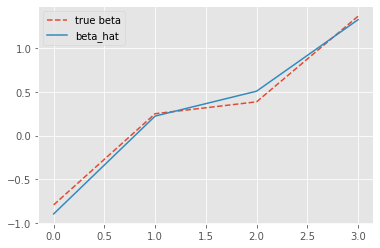

In [359]:
key = random.PRNGKey(20220519)

n = 100
p = 4


def sample_x(key):
    x = random.normal(key, (n, p))
    return x

def sample_beta(key):
    beta = random.normal(key, (p,))
    return beta

def sample_y(key, beta, x):
    eps = random.normal(key, (n,))
    y = x @ beta + eps
    return y

key, skey1, skey2, skey3 = random.split(key, 4)

x = sample_x(skey1)
beta = sample_beta(skey2)
y = sample_y(skey3, beta, x)


def loss(beta, x, y):
    y_hat = x @ beta
    return jnp.mean((y - y_hat)**2)


def fit_beta(x, y):
    res = jso.minimize(loss, jnp.zeros(p), args=(x, y), method="BFGS")
    return res.x

beta_hat = fit_beta(x, y)

plt.plot(beta, '--', label='true beta')
plt.plot(beta_hat, label='beta_hat')
plt.legend()
plt.show()

In [360]:
# bootstrap

def replicate(key, beta, x):
    y = sample_y(key, beta, x)
    beta_hat = fit_beta(x, y)
    return beta_hat

n_replications = 10_000
bootstrap = jax.jit(jax.vmap(replicate, in_axes=(0, None, None)))


In [361]:
%%time
keys = random.split(key, n_replications)
beta_s = bootstrap(keys, beta, x).block_until_ready()

CPU times: user 2.95 s, sys: 217 ms, total: 3.17 s
Wall time: 2.18 s


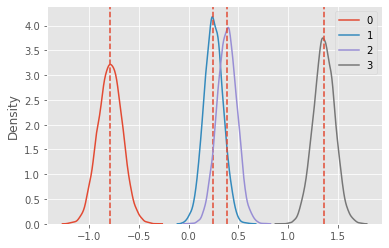

In [362]:
df = pd.DataFrame(beta_s)

for i in range(p):
    sns.kdeplot(beta_s[:, i], label=str(i))
    plt.axvline(x=beta[i], ls='--')
plt.legend()
plt.show()

In [228]:

beta_start = jnp.zeros(p)

true_hess_inv = jnp.linalg.inv(jax.hessian(loss)(beta_start, x, y))
true_grad = jax.grad(loss)(beta_start, x, y)

beta_hat = beta_start - true_hess_inv @ true_grad

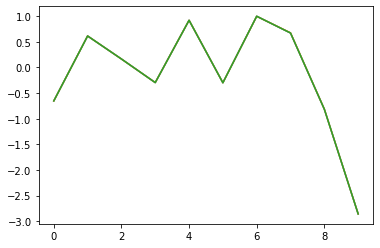

In [229]:
plt.plot(beta_hat)
plt.plot(beta)
plt.plot(res.x)

In [254]:
from typing import Callable, NamedTuple, Optional, Union
from jax import lax

class _NewtonResults(NamedTuple):
    """Results from optimization.
    Parameters:
    converged: True if minimization converged.
    failed: True if line search failed.
    k: integer the number of iterations of the BFGS update.
    nfev: integer total number of objective evaluations performed.
    ngev: integer total number of jacobian evaluations
    nhev: integer total number of hessian evaluations
    x_k: array containing the last argument value found during the search. If
    the search converged, then this value is the argmin of the objective
    function.
    f_k: array containing the value of the objective function at `x_k`. If the
    search converged, then this is the (local) minimum of the objective
    function.
    g_k: array containing the gradient of the objective function at `x_k`. If
    the search converged the l2-norm of this tensor should be below the
    tolerance.
    H_k: array containing the inverse of the Hessian.
    status: int describing end state.
    line_search_status: int describing line search end state (only means
    something if line search fails).
    """
    converged: Union[bool, jnp.ndarray]
    failed: Union[bool, jnp.ndarray]
    k: Union[int, jnp.ndarray]
    nfev: Union[int, jnp.ndarray]
    ngev: Union[int, jnp.ndarray]
    nhev: Union[int, jnp.ndarray]
    x_k: jnp.ndarray
    f_k: jnp.ndarray
    g_k: jnp.ndarray
    H_k: jnp.ndarray
    old_old_fval: jnp.ndarray
    status: Union[int, jnp.ndarray]
    line_search_status: Union[int, jnp.ndarray]


def minimize_newton(fun,
                    x0,
                    maxiter=None,
                    norm=jnp.inf,
                    gtol: float = 1e-5):
    if maxiter is None:
        maxiter = jnp.size(x0) * 200

    f = fun
    df = jax.grad(f)
    d2f = jax.hessian(f)
    
    f_0 = f(x0)
    g_0 = df(x0)
    H_0 = d2f(x0)
    
    state = _NewtonResults(
        converged=jnp.linalg.norm(g_0, ord=norm) < gtol,
        failed=False,
        k=0,
        nfev=1,
        ngev=1,
        nhev=1,
        x_k=x0,
        f_k=f_0,
        g_k=g_0,
        H_k=H_0,
        old_old_fval=f_0 + jnp.linalg.norm(g_0) / 2,
        status=0,
        line_search_status=0,
    )
    
    def cond_fun(state):
        return (jnp.logical_not(state.converged)
                & jnp.logical_not(state.failed)
                & (state.k < maxiter))
    
    def body_fun(state):
        p_k = -jnp.linalg.solve(state.H_k, state.g_k)
        x_kp1 = state.x_k + p_k
        
        f_kp1 = f(x_kp1)
        g_kp1 = df(x_kp1)
        H_kp1 = d2f(x_kp1)
        
        converged = jnp.linalg.norm(g_kp1, ord=norm) < gtol

        state = state._replace(
            converged=converged,
            k=state.k + 1,
            nfev=state.nfev + 1,
            ngev=state.ngev + 1,
            nhev=state.nhev + 1,
            x_k=x_kp1,
            f_k=f_kp1,
            g_k=g_kp1,
            H_k=H_kp1,
            old_old_fval=state.f_k,
        )
        return state

    state = lax.while_loop(cond_fun, body_fun, state)
    return state


loss2 = lambda beta: loss(beta, x, y)

minimize_newton(loss2, jnp.zeros(p), 10)

@jax.jit
def solve(x0):
    return minimize_newton(loss2, x0, 10)


In [255]:
%%timeit
solve(jnp.zeros(p))

879 µs ± 88.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [256]:
res = solve(jnp.zeros(p))

In [257]:
res.x_k

DeviceArray([-0.65403825,  0.6110066 ,  0.16271512, -0.29708645,
              0.9171779 , -0.3002871 ,  0.99557877,  0.66878027,
             -0.81564283, -2.8557467 ], dtype=float32)

In [258]:
res

_NewtonResults(converged=DeviceArray(True, dtype=bool), failed=DeviceArray(False, dtype=bool, weak_type=True), k=DeviceArray(2, dtype=int32, weak_type=True), nfev=DeviceArray(3, dtype=int32, weak_type=True), ngev=DeviceArray(3, dtype=int32, weak_type=True), nhev=DeviceArray(3, dtype=int32, weak_type=True), x_k=DeviceArray([-0.65403825,  0.6110066 ,  0.16271512, -0.29708645,
              0.9171779 , -0.3002871 ,  0.99557877,  0.66878027,
             -0.81564283, -2.8557467 ], dtype=float32), f_k=DeviceArray(0.00994402, dtype=float32), g_k=DeviceArray([-2.4893662e-08,  2.0160746e-08,  7.7279099e-09,
             -1.8590665e-08,  3.6768533e-08, -1.7380936e-08,
             -2.6043224e-08, -1.6824860e-08, -3.6699877e-08,
              1.5586375e-07], dtype=float32), H_k=DeviceArray([[ 2.02082682e+00, -2.06587482e-02,  2.87326835e-02,
              -3.98540217e-03, -5.05757006e-03, -1.14756208e-02,
              -3.86415981e-04,  2.03384217e-02,  3.52344550e-02,
               1.03588961e

In [259]:
key

DeviceArray([1465915615, 2939002660], dtype=uint32)

In [260]:
subkey

DeviceArray([3917011293, 2594701472], dtype=uint32)

In [266]:
random.split(key, 1)

DeviceArray([[  69879142, 1075542405]], dtype=uint32)

DeviceArray([1465915615, 2939002660], dtype=uint32)